# Mortgage Cashflow Case Study
## Code+Output
Anurag Sharma
   
Septemper 8th, 2024

## I. Definitions
In an attempt to explore the problem, I have consulted various sources from the internet. The following definitions and references are handy to understand the case study:



- **Prepayment**: The full and early repayment of a mortgage loan before its scheduled maturity date. This often occurs when borrowers refinance their mortgage or sell their property.

- **Default**: A situation where the borrower misses three consecutive mortgage payments. Once a loan enters default status, it cannot be reversed or "cured." This typically triggers foreclosure proceedings.

- **Recovery**: Any payments or funds received from the borrower after the loan has been flagged as in default. This may include partial payments, proceeds from property sale, or other sources.

- **Balance**: The total amount of debt still owed by the borrower on their mortgage loan at any given time. This includes the principal and any accrued interest or fees.

- **SMM (Single Monthly Mortality)**: A measure of the prepayment rate for a pool of mortgages, calculated as:

  $SMM = \frac{\sum(\text{Balance at T that enters into Prepayment at T+1})}{\sum(\text{Balance at T that has not Defaulted or Prepaid at T})}$

- **MDR (Monthly Default Rate)**: A measure of the default rate for a pool of mortgages, calculated as:

  $MDR = \frac{\sum(\text{Balance at T that enters into Default at T+1})}{\sum(\text{Balance at T that has not Defaulted or Prepaid at T})}$

- **CPR (Conditional Prepayment Rate)**: An annualized measure of prepayment, derived from the SMM:

  $CPR = 1 - (1 - SMM)^{12}$

  This represents the percentage of the mortgage pool's principal that would prepay over a year if the SMM rate remained constant for 12 months.

- **CDR (Conditional Default Rate)**: An annualized measure of default, derived from the MDR:

  $CDR = 1 - (1 - MDR)^{12}$

  This represents the percentage of the mortgage pool's principal that would default over a year if the MDR remained constant for 12 months.

References can be found in [1](https://financetrain.com/single-monthly-mortality-smm-conditional-prepayment-rate-cpr), [2](https://www.investopedia.com/terms/c/constant-default-rate.asp), [3](https://cbonds.com/glossary/) among others.


## II. Project Overview


This case study focuses on analyzing and modeling a mortgage portfolio that a Seller is looking to divest. The project involves data consolidation, statistical analysis, and the development of a robust cashflow model to forecast various scenarios.


### Goals

1. **Data Consolidation and Enhancement**: Merging static and historic data into a comprehensive dataset, adding calculated fields for deeper analysis.

2. **Portfolio Performance Analysis**: Develop functions to calculate and analyze Prepayment (CPR), Default (CDR), and Recovery curves across different loan attributes.

3. **Cashflow Model Development**: Create a Python-based cashflow model capable of forecasting loan-level and portfolio-level cashflows under various scenarios.

4. **Scenario Analysis**: Implement and analyze multiple scenarios to understand portfolio behavior under different conditions.

5. **Model Validation**: Establish sanity checks and error-catching mechanisms to ensure model reliability.


### Non-Goals

1. Predicting future market conditions or economic factors affecting the mortgage industry.
2. Developing a user interface for the model (focus is on backend functionality).
3. Integrating with external data sources or real-time data feeds.


### Focus Areas

Our primary focus in this study has been on:

1. **Data Manipulation and Analysis**: Utilizing pandas for efficient data handling and calculation of key metrics.

2. **Statistical Modeling**: Developing reusable functions for curve calculations (CPR, CDR, Recovery) with flexible pivoting capabilities.

3. **Performance Optimization**: Ensuring the cashflow model can handle large portfolios efficiently, potentially using tools like numba or multiprocessing.

4. **Scenario Flexibility**: Designing the model to easily accommodate various scenarios and configurations for analyst use.

5. **Model Integrity**: Implementing comprehensive sanity checks and error-catching mechanisms to validate model outputs.


## III. Data Exploration

### Dependencies: Import Libraries to be used for analysis

In [1]:

import sys
sys.path.append('..')
from src.data_processing import (
    excel_to_dataframe,
    merge_static_and_monthly,
    calculate_seasoning,
    calculate_n_missed_payments,
    calculate_prepaid_in_month,
    calculate_default_in_month,
    plot_distribution,
    plot_loan_characteristics,
    plot_distribution_by_category,
    calculate_recovery_in_month,
    calculate_is_recovery_payment,
    calculate_time_to_reversion,
    calculate_date_of_default,
    calculate_current_balance,
    calculate_postdefault_recoveries,
    calculate_prepayment_date,
    calculate_date_of_recovery,
    calculate_exposure_at_default,
    calculate_recovery_percent,
    plot_curves,
    calculate_months_since_default,
    calculate_recovery_curve,
    calculate_curves,
    summary
)

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_rows', 500)

%load_ext autoreload
%autoreload 2

### Data Files and other resources

In [2]:
file_path = "../data/2024-Case.xlsx"
sheet_static = "DATA-Static" 
sheet_month_end = "DATA-Month End Balances"
sheet_payments_due = "DATA-Payment Due" 
sheet_payments_made = "DATA-Payment Made"

The `excel_to_dataframe` function is a utility designed to read sheets from Excel files into pandas DataFrames. It has an option to specify the starting row of content for each sheet, allowing for flexible handling of headers and metadata.

In [3]:
df_static = excel_to_dataframe(file_path, sheet_static, header_start=(2,1))
me_df = excel_to_dataframe(file_path, sheet_month_end)
payments_due_df = excel_to_dataframe(file_path, sheet_payments_due)
payments_made_df = excel_to_dataframe(file_path, sheet_payments_made)

In [4]:
summary(df_static, "Static Data")

Summary Statistics for Static Data
----------------------------------------

Shape of Static Data: (1630, 8)

First few rows of Static Data:
  loan_id origination_date investor_1_acquisition_date reversion_date original_balance product pre_reversion_fixed_rate post_reversion_boe_margin
0       1       2020-12-31                  2020-12-31     2022-12-31           150876       1                 0.019881                    0.0375
1       2       2020-07-31                  2020-12-31     2022-07-31           103580       1                 0.019947                    0.0375
2       3       2018-02-28                  2020-12-31     2020-02-28            89311       1                 0.029331                    0.0375
3       4       2017-04-30                  2020-12-31     2019-04-30           123170       1                 0.027889                    0.0375
4       5       2021-06-30                  2021-06-30     2023-06-30           139657       1                  0.01993          

<Figure size 1200x600 with 0 Axes>

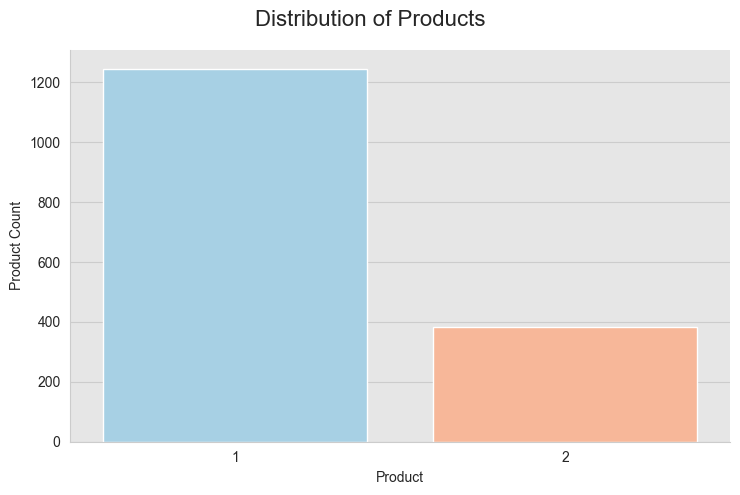

In [5]:
fig = plot_distribution(df_static)
plt.show()

Below we examine the distribution of origination and reversion dates across different years in our mortgage portfolio.

In [6]:
display(df_static.origination_date.dt.year.value_counts(dropna=False).sort_values(na_position='first',ascending=False).head(20))

origination_date
2022    469
2021    412
2020    304
2019    231
2018    118
2017     57
2016     39
Name: count, dtype: int64

In [7]:
display(df_static.reversion_date.dt.year.value_counts(dropna=False).sort_values(na_position='first',ascending=False).head(20))


reversion_date
2024    469
2023    412
2022    304
2021    231
2020    118
2019     57
2018     39
Name: count, dtype: int64

`plot_loan_characteristics` is used to visualize key loan attributes across different product types. This function generates a FacetGrid scatter plot, allowing us to understand multiple dimensions of our mortgage portfolio simultaneously.

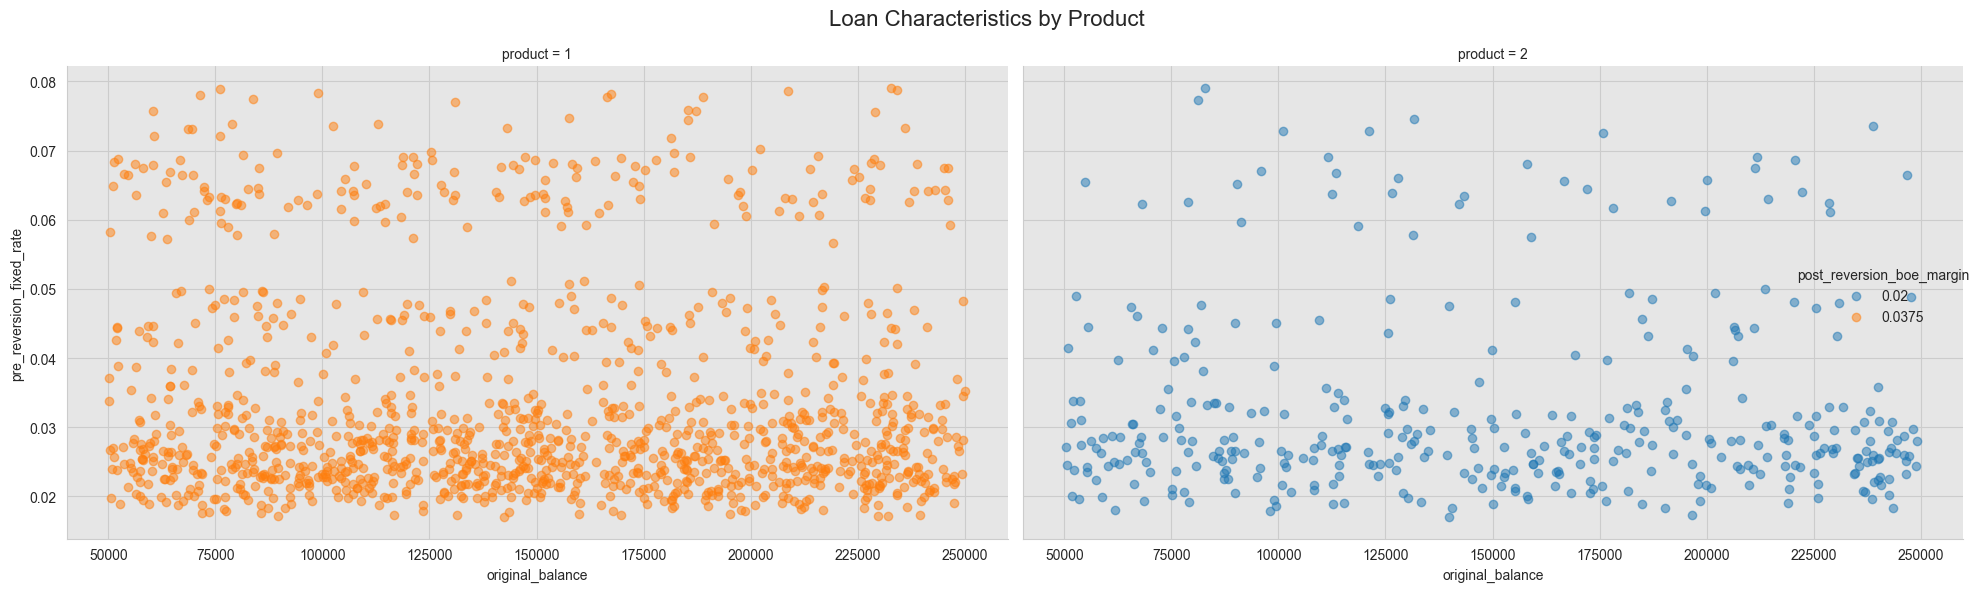

In [8]:
fig = plot_loan_characteristics(df_static, 
                                "original_balance", 
                                "pre_reversion_fixed_rate", 
                                "post_reversion_boe_margin", 
                                "product", 
                                "Loan Characteristics by Product")
plt.show()

We have some recipes to visualize categorical variables in the dataset. The `plot_categorical_distribution` function generates a bar plot showing the distribution of a specified categorical variable. If a target variable is provided, it also displays the distribution split by the target variable.

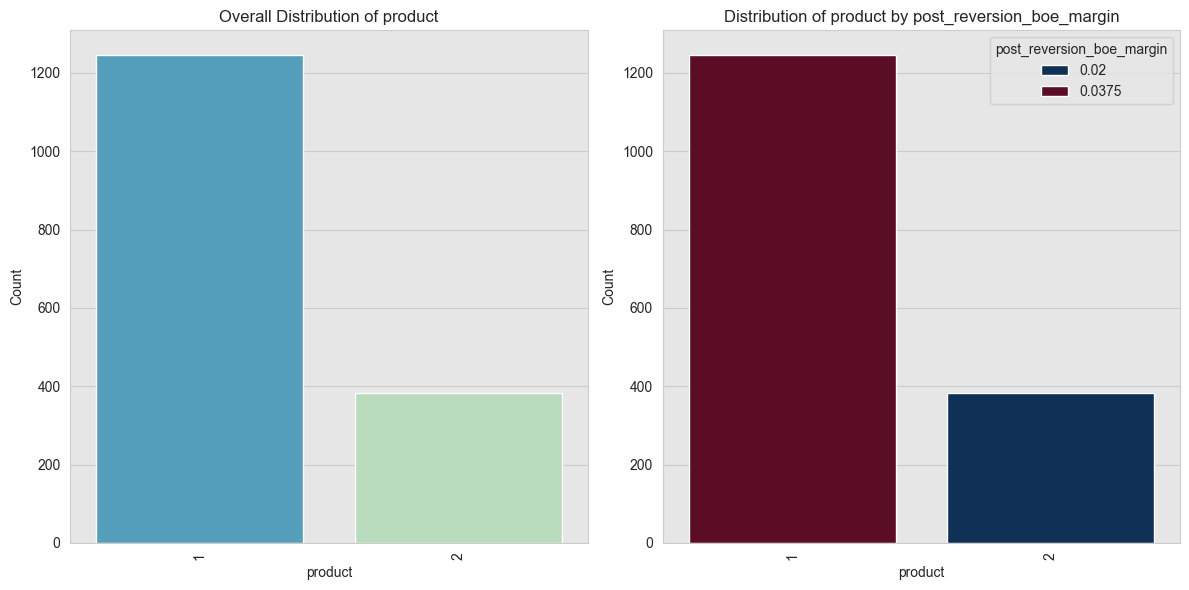

In [9]:
g, h = plot_distribution_by_category(df_static, "product", "post_reversion_boe_margin")
plt.show()

# Q1.

`merge_static_and_monthly` combines static loan information with monthly performance data, creating a comprehensive view of a mortgage portfolio.
It merges static loan details with dynamic monthly data, enabling a complete picture of each loan's performance over time. 

This view also in tracking of key metrics (e.g., defaults, prepayments) across the entire portfolio and individual loans.

**Note**: This is not generic enough to merge arbitrary datasets, as it assumes specific columns and data structures.

In [10]:
df = merge_static_and_monthly(static_df=df_static, monthly_dfs=[me_df, payments_due_df, payments_made_df], column_names = ["me_balances", "payment_due", "payment_made"])

In [11]:
df.head().T

,0,1,2,3,4
loan_id,1,1,1,1,1
month,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2016-05-31 00:00:00
me_balances,NaN,NaN,NaN,NaN,NaN
payment_due,NaN,NaN,NaN,NaN,NaN
payment_made,NaN,NaN,NaN,NaN,NaN
origination_date,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00
investor_1_acquisition_date,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00
reversion_date,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
original_balance,150876,150876,150876,150876,150876
product,1,1,1,1,1


In [12]:
df.tail().T

,136915,136916,136917,136918,136919
loan_id,999,999,999,999,999
month,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
me_balances,150473,150473,150473,150473,150473
payment_due,689.667917,752.365,752.365,846.410625,909.107708
payment_made,689.667917,752.365,752.365,846.410625,909.107708
origination_date,2016-04-30 00:00:00,2016-04-30 00:00:00,2016-04-30 00:00:00,2016-04-30 00:00:00,2016-04-30 00:00:00
investor_1_acquisition_date,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00,2020-12-31 00:00:00
reversion_date,2018-04-30 00:00:00,2018-04-30 00:00:00,2018-04-30 00:00:00,2018-04-30 00:00:00,2018-04-30 00:00:00
original_balance,150473,150473,150473,150473,150473
product,1,1,1,1,1


In [13]:
df.dtypes

loan_id                                object
month                          datetime64[ns]
me_balances                            object
payment_due                           float64
payment_made                          float64
origination_date               datetime64[ns]
investor_1_acquisition_date    datetime64[ns]
reversion_date                 datetime64[ns]
original_balance                       object
product                                object
pre_reversion_fixed_rate               object
post_reversion_boe_margin              object
dtype: object

## IV. Data Cleaning
It appears that our data needs may not need cleaning.  

* Check for nulls and if nulls are present in a significant volume, I prefer to create a flag which detects if the field was missing.


The presence of null values in `me_balances`, `payment_due`, and `payment_made`—is an expected in our dataset. This is attributable to two factors:

- Varying Loan Tenors: Loans within the portfolio have different durations.
- Differing Holding Periods: The duration for which each loan has been held in the portfolio varies. More recent acquisitions will have fewer historical data points compared to long-standing loans.


In [14]:
df.isnull().sum()

loan_id                            0
month                              0
me_balances                    94309
payment_due                    99750
payment_made                   99750
origination_date                   0
investor_1_acquisition_date        0
reversion_date                     0
original_balance                   0
product                            0
pre_reversion_fixed_rate           0
post_reversion_boe_margin          0
dtype: int64

# Q2

## V. Data Engineering

Our analysis requires the creation of additional columns to to calculate metrics for loan performance and risk factors. We'll add both dynamic and static columns to our dataset.

### Dynamic Columns

These columns capture changing aspects of each loan over time:

- current_balance: The remaining unpaid principal of the loan at a given point in time.
- seasoning: The age of the loan in months since origination.
- n_missed_payments: The number of payments the borrower has failed to make on time.
- prepaid_in_month: Indicates if the loan was prepaid in a given month.
- default_in_month: Indicates if the loan defaulted in a given month.
- recovery_in_month: Indicates if any recovery was made on a defaulted loan in a given month.
- is_recovery_payment: Flags payments made after a loan has defaulted.
- time_to_reversion: The number of months until the loan's interest rate adjusts (for adjustable-rate mortgages).
- months_since_default: The number of months that have passed since the loan defaulted.

### Static Columns

These columns provide important fixed information about each loan:

- date_of_default: The date when the loan was officially classified as defaulted.
- postdefault_recoveries: The total amount recovered after the loan defaulted.
- date_of_recovery: The date when the full defaulted amount was recovered (if applicable).
- prepayment_date: The date when the loan was fully paid off before its scheduled term.
- exposure_at_default: The total amount owed at the time of default.
- recovery_percent: Calculates - The percentage of the exposure at default that was recovered, calculated as (postdefault_recoveries / exposure_at_default) * 100.

### Implementation Strategy

We use helper functions in `data_processing.py` library to enhance our dataset. 

**Note:** the order of column creation is crucial due to dependencies between columns. Some new columns rely on values calculated in previously created columns. For instance:
1. We first determine the date_of_default.
2. This allows us to calculate postdefault_recoveries.

#### How to Add New Columns

To add a new column to the dataset, follow these steps:

1. Define the calculation logic: Determine what the new column should represent and how it should be calculated.

2. Create a helper function: Write a new function in the `data_processing.py` file that implements the calculation logic.

3. Consider dependencies: If the new column depends on other columns, ensure it's added after its dependencies in the processing order.

4. Write tests in `test_data_processing.py`: Add test cases to verify the correctness of the new column.


We have to distinct code paths for adding new columns to the dataset. This is necessary due to the different nature of static and dynamic data in our mortgage portfolio analysis. Dynamic columns represent data that evolves monthly for each loan, such as current balance or number of missed payments. Pandas columnar operations allow us to perform these calculations efficiently across the entire dataset at once, using vectorized operations.

Static columns contain information that doesn't change monthly but needs to be associated with each monthly record of a loan. For example, the date of default is a one-time event, but we need this information available for every month of the loan's history. Left joins allow us to efficiently propagate this static information across all relevant rows.






In [15]:
# Add dynamic columns
dynamic_columns = {
    "current_balance": calculate_current_balance,
    "seasoning": calculate_seasoning,
    "n_missed_payments": calculate_n_missed_payments,
    "prepaid_in_month": calculate_prepaid_in_month,
    "default_in_month": calculate_default_in_month,
    "recovery_in_month": calculate_recovery_in_month,
    "is_recovery_payment": calculate_is_recovery_payment,
    "time_to_reversion": calculate_time_to_reversion,
    
}

for column_name, column_function in dynamic_columns.items():
    df[column_name] = column_function(df)

In [16]:
# Add Static columns
df = calculate_date_of_default(df)
df = calculate_postdefault_recoveries(df)
df = calculate_date_of_recovery(df)
df = calculate_prepayment_date(df)
df = calculate_exposure_at_default(df)
df = calculate_exposure_at_default(df)
df = calculate_recovery_percent(df)

In [17]:
# Add another dynamic column which is dependent on the static columns
df["months_since_default"] = calculate_months_since_default(df)

# Q3

### SMM, CPR and CDR Curves

#### Single Monthly Mortality (SMM)

Single Monthly Mortality (SMM) represents the percentage of outstanding mortgage balance that is prepaid in a given month. It's a measure of the prepayment speed of a mortgage pool.

$$
\text{SMM} = \frac{\text{Prepayment Amount}}{\text{Beginning Balance}} \times 100\%
$$

#### Conditional Prepayment Rate (CPR)

Conditional Prepayment Rate (CPR) is the annualized rate of prepayment, assuming that the mortgages that haven't prepaid up to that point will continue to perform.

CPR can be calculated from SMM using:

$$
\text{CPR} = 1 - (1 - \text{SMM})^{12}
$$

Conversely, SMM can be derived from CPR:

$$
\text{SMM} = 1 - (1 - \text{CPR})^{\frac{1}{12}}
$$


#### Conditional Default Rate (CDR)

Conditional Default Rate (CDR) is the annualized rate of default, assuming that the mortgages that haven't defaulted up to that point will continue to perform.

The monthly CDR can be converted to an annual rate using:

$$
\text{Annual CDR} = 1 - (1 - \text{Monthly CDR})^{12}
$$



SMM, CDR, and CPR curves represent these rates over time. They are typically plotted with time (seasoning) on the x-axis and the respective rate on the y-axis.

1. **SMM Curve**: Shows the monthly prepayment rate over time.
2. **CPR Curve**: Illustrates the annualized prepayment rate over time.
3. **CDR Curve**: Displays the annualized default rate over time.

In [18]:
df_cpr_smm = calculate_curves(df, ["prepayment"])


In [19]:
df_cpr_smm.head().T

,0,1,2,3,4
seasoning,0.0,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
current_balance,243924156.0,2.350971e+08,2.292465e+08,2.229757e+08,2.179006e+08
prepayment,0.0,4.441980e+05,1.237850e+05,8.249500e+04,2.269860e+05
SMM,0.0,1.889423e-03,5.399647e-04,3.699731e-04,1.041695e-03
CPR,0.0,2.243894e+00,6.460368e-01,4.430654e-01,1.242897e+00


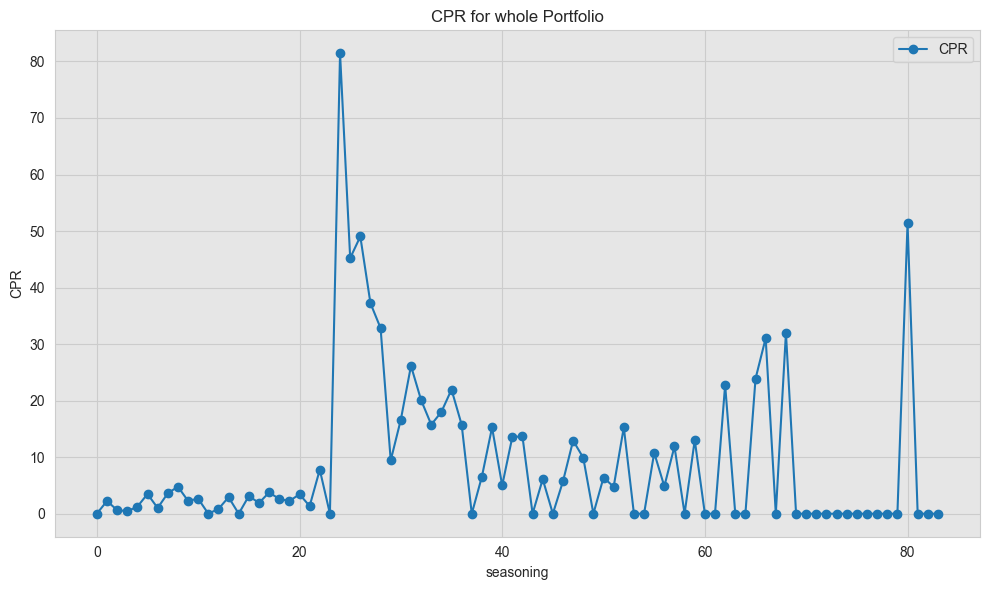

In [20]:
plot_curves([{'x': df_cpr_smm["seasoning"], 'y': df_cpr_smm["CPR"], 'label': 'CPR'}], 'CPR for whole Portfolio', 'seasoning', 'CPR')



In [21]:
# Save the curve for using in the next notebook
df_cpr_smm[["seasoning", "CPR"]].to_csv("../data/cpr.csv", index=False)

In [22]:
df_cpr_smm_product = calculate_curves(df, ["prepayment"], pivots=["product"])

In [23]:
df_cpr_smm_product.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
seasoning,0.0,1.000000,2.00000,3.000000,4.000000,5.000000,6.000000,7.000000,8.00000,9.000000,10.000000,11.0,12.000000,13.000000,14.0
cpr_1,0.0,2.948079,0.85075,0.584791,1.641502,2.211299,0.000000,4.772894,6.30045,1.907058,0.677591,0.0,1.120569,3.396084,0.0
cpr_2,0.0,0.000000,0.00000,0.000000,0.000000,7.306554,4.036183,0.000000,0.00000,3.395977,8.370722,0.0,0.000000,1.566925,0.0


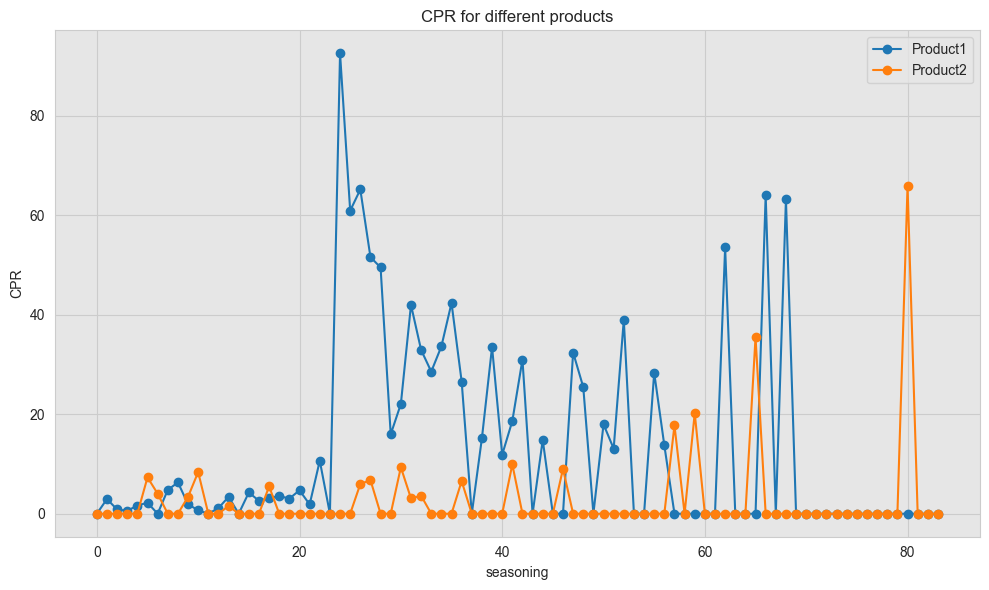

In [24]:
plot_curves([{'x': df_cpr_smm_product["seasoning"], 'y': df_cpr_smm_product["cpr_1"], 'label': 'Product1'}, {'x': df_cpr_smm_product["seasoning"], 'y': df_cpr_smm_product["cpr_2"], 'label': 'Product2'}], 'CPR for different products', 'seasoning', 'CPR')


# Q4

CDR and CPR are similar curves, so we leverage the same function to calculate both. The `calculate_curve` function computes the monthly rate of prepayment or default for each seasoning period in the dataset. It then annualizes these rates to generate the CPR or CDR curve. We have an internal battery that sets the curve type and the corresponding column names for the calculation.

In [25]:
df_cdr_mdr = calculate_curves(df, ["default"])


In [26]:
df_cdr_mdr.head().T

,0,1,2,3,4
seasoning,0.0,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
current_balance,243924156.0,2.350971e+08,2.292465e+08,2.229757e+08,2.179006e+08
amount_default,0.0,0.000000e+00,0.000000e+00,4.659810e+05,5.908959e+05
MDR,0.0,0.000000e+00,0.000000e+00,2.089829e-03,2.711769e-03
CDR,0.0,0.000000e+00,0.000000e+00,2.479170e+00,3.206024e+00


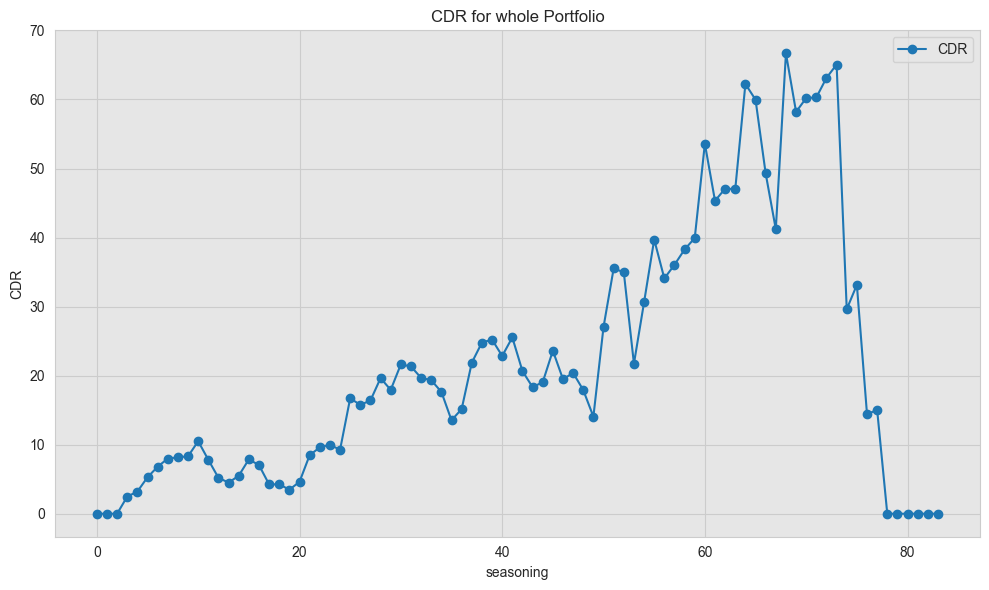

In [27]:
plot_curves([{'x': df_cdr_mdr["seasoning"], 'y': df_cdr_mdr["CDR"], 'label': 'CDR'}], 'CDR for whole Portfolio', 'seasoning', 'CDR')

In [28]:
# Save the curve for using in the next notebook
df_cdr_mdr[["seasoning", "CDR"]].to_csv("../data/cdr.csv", index=False)

# Q5, Q7 and Q8


The recovery rate curves are a little different compared to the Conditional Prepayment Rate (CPR):

1. **Time Axis**: Recovery rates are plotted against "months since default" rather than the seasoning (both CDR and CPR) timeline.

2. **Mutual Exclusivity**: Recovery and prepayment are mutually exclusive events in a loan's lifecycle. A loan that has defaulted cannot be prepaid, and vice versa.

While the recovery rate calculation function shares similarities with the CPR function, we prioritize clarity over code reuse. This approach allows for independent modifications to either the CPR or recovery rate calculations without risking unintended side effects.


In [29]:
df_recovery = calculate_recovery_curve(df)

In [30]:
df_recovery.head().T

,0,1,2,3,4
months_since_default,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
postdefault_recoveries,0.000000e+00,0.000000e+00,0.000000e+00,2.114067e+06,9.837706e+05
exposure_at_default,9.181639e+06,8.808379e+06,8.031003e+06,7.400021e+06,6.877073e+06
postdefault_recoveries_cumsum,0.000000e+00,0.000000e+00,0.000000e+00,2.114067e+06,3.097837e+06
recovery_percent,0.000000e+00,0.000000e+00,0.000000e+00,2.302494e+01,3.373948e+01


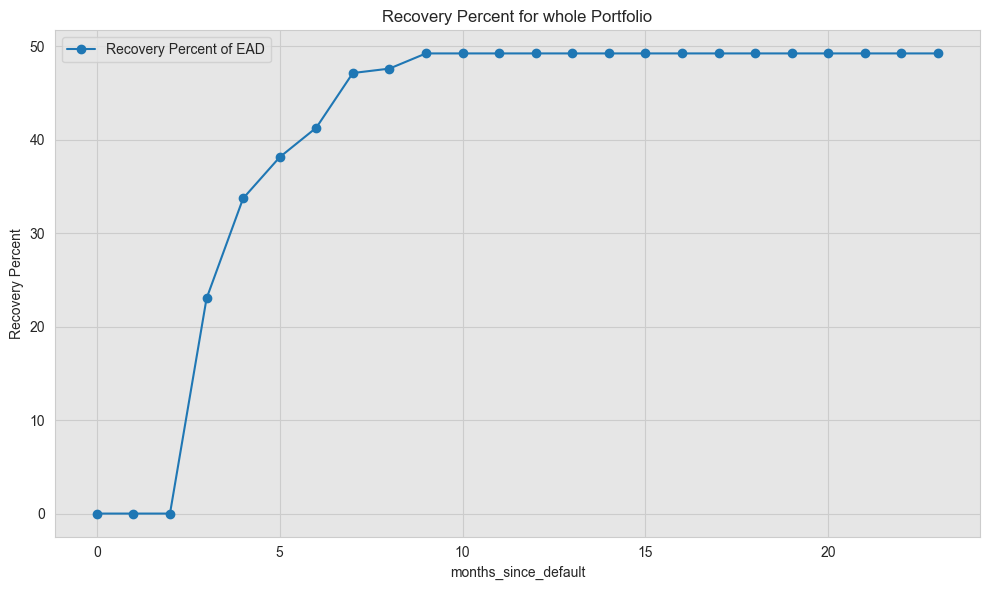

In [31]:
plot_curves([{'x': df_recovery["months_since_default"], 'y': df_recovery["recovery_percent"], 'label': 'Recovery Percent of EAD'}], 'Recovery Percent for whole Portfolio', 'months_since_default', 'Recovery Percent')

In [32]:
df_recovery_with_vintage = calculate_recovery_curve(df, include_default_vintage=True)

In [33]:
df_recovery_with_vintage.head().T

,0,1,2,3,4
year_of_default,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03
months_since_default,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
postdefault_recoveries,0.000000e+00,0.000000e+00,0.000000e+00,1.054487e+06,8.933749e+05
exposure_at_default,3.371087e+06,3.371087e+06,3.371087e+06,3.371087e+06,3.371087e+06
postdefault_recoveries_cumsum,0.000000e+00,0.000000e+00,0.000000e+00,1.054487e+06,1.947862e+06
recovery_percent,0.000000e+00,0.000000e+00,0.000000e+00,3.128033e+01,5.778142e+01


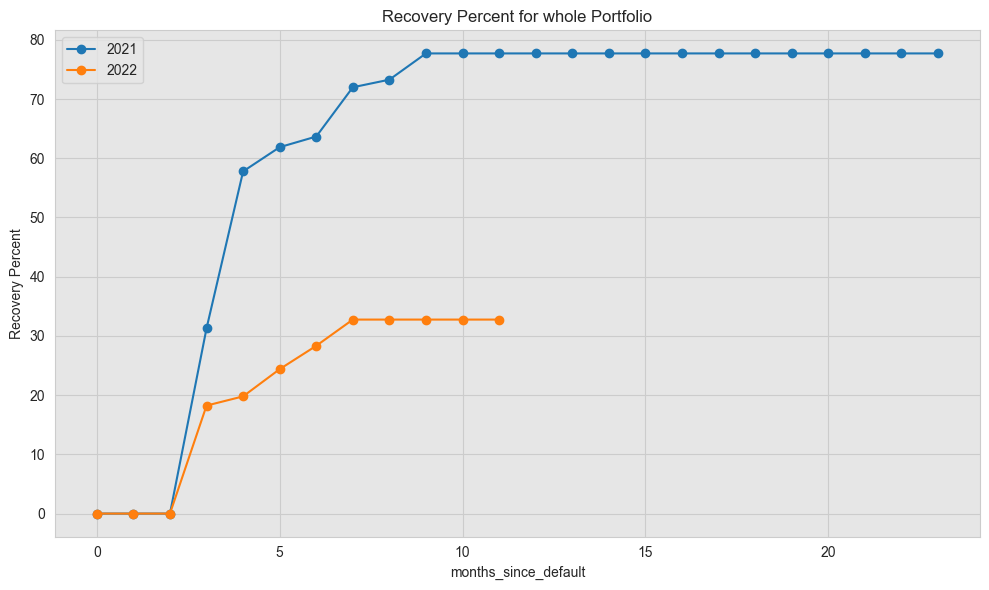

In [34]:
df_2021 = df_recovery_with_vintage[df_recovery_with_vintage["year_of_default"] == 2021]
df_2022 = df_recovery_with_vintage[df_recovery_with_vintage["year_of_default"] == 2022]

plot_curves([{'x': df_2021["months_since_default"], 'y':df_2021["recovery_percent"], 'label': '2021'}, {'x': df_2022["months_since_default"], 'y':df_2022["recovery_percent"], 'label': '2022'}], 'Recovery Percent for whole Portfolio', 'months_since_default', 'Recovery Percent')

**Note**: Ambiguity in Recovery Curve Decomposition (Q.8)

There is some ambiguity in the decomposition requested in Question 8, given the analysis already performed in Questions 5 and 7. Here's the issue:

In Q5/Q7, we've already plotted the cumulative recoveries as a percentage of Exposure at Default (EAD). Q8 asks to decompose this curve into two stages:
(1) Probability of Recovery by Time Since Default
(2) Recovery as a % of EAD

The ambiguity arises because the second part of the decomposition (Recovery as a % of EAD) seems to be what we've already calculated in Q5/Q7. This makes it somewhat unclear how to further decompose the curve using a similar metric.

We have tried to plot expected recovery against postdefault recoveries below.

In [35]:
df_recovery["total_recovery"] = df_recovery["postdefault_recoveries"].sum()
df_recovery["prob_recovery"] = df_recovery["postdefault_recoveries"] / df_recovery["total_recovery"]

In [36]:
df_recovery.head().T

,0,1,2,3,4
months_since_default,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
postdefault_recoveries,0.000000e+00,0.000000e+00,0.000000e+00,2.114067e+06,9.837706e+05
exposure_at_default,9.181639e+06,8.808379e+06,8.031003e+06,7.400021e+06,6.877073e+06
postdefault_recoveries_cumsum,0.000000e+00,0.000000e+00,0.000000e+00,2.114067e+06,3.097837e+06
recovery_percent,0.000000e+00,0.000000e+00,0.000000e+00,2.302494e+01,3.373948e+01
total_recovery,4.522708e+06,4.522708e+06,4.522708e+06,4.522708e+06,4.522708e+06
prob_recovery,0.000000e+00,0.000000e+00,0.000000e+00,4.674337e-01,2.175180e-01


<Axes: >

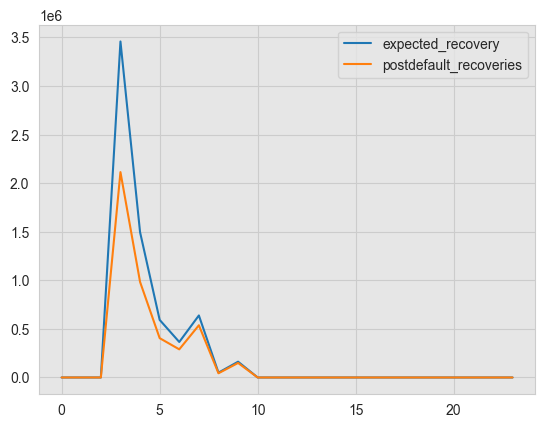

In [37]:
df_recovery["expected_recovery"] = df_recovery["prob_recovery"] * df_recovery["exposure_at_default"]
df_recovery[["expected_recovery", "postdefault_recoveries"]].plot()

In [38]:
# Save the curve for using in the next notebook
df_recovery[["months_since_default", "recovery_percent"]].to_csv("../data/recovery.csv", index=False)

# Q6

CPR (Conditional Prepayment Rate) and CDR (Conditional Default Rate) curves against time to reversion are very similar to those against seasoning, with the primary difference being the choice of the x-axis variable (primary pivot). 

While seasoning curves measure from the loan's origination date, time to reversion curves measure from the current date to the loan's rate reset date.

The calculation method remains the same for both approaches, involving the aggregation of loan-level data into time buckets. To switch between these curve types, we simply change the primary pivot in our calculation function from 'seasoning' to 'time_to_reversion'. 

Hence we made our funcction `calculate_curve` flexible enough to handle both scenarios.


In [39]:
df_cpr_cdr_t2rev = calculate_curves(df, ['prepayment', 'default'], pivots=['time_to_reversion', 'product'], primary_pivot='time_to_reversion')

In [40]:
df_cpr_cdr_t2rev.head().T

,0,1,2,3,4
time_to_reversion,-24.0,-23.000000,-22.00000,-21.000000,-20.000000
cdr_1,0.0,0.000000,0.00000,3.262317,4.221731
cdr_2,0.0,0.000000,0.00000,0.000000,0.000000
cpr_1,0.0,2.948079,0.85075,0.584791,1.641502
cpr_2,0.0,0.000000,0.00000,0.000000,0.000000


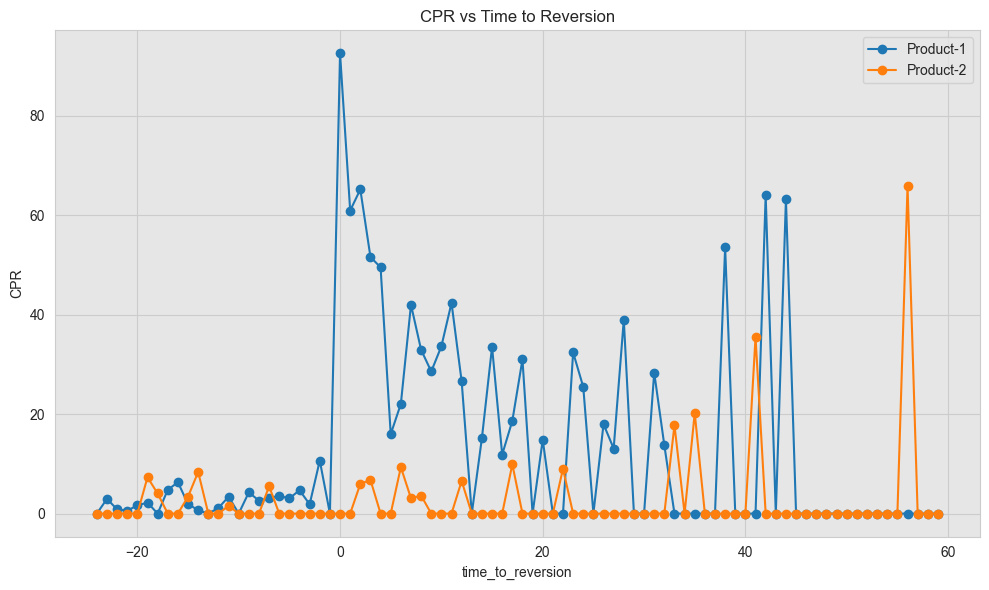

In [41]:
plot_curves([{'x': df_cpr_cdr_t2rev["time_to_reversion"], 'y':df_cpr_cdr_t2rev["cpr_1"], 'label': 'Product-1'}, {'x': df_cpr_cdr_t2rev["time_to_reversion"], 'y':df_cpr_cdr_t2rev["cpr_2"], 'label': 'Product-2'}], 'CPR vs Time to Reversion', 'time_to_reversion', 'CPR')

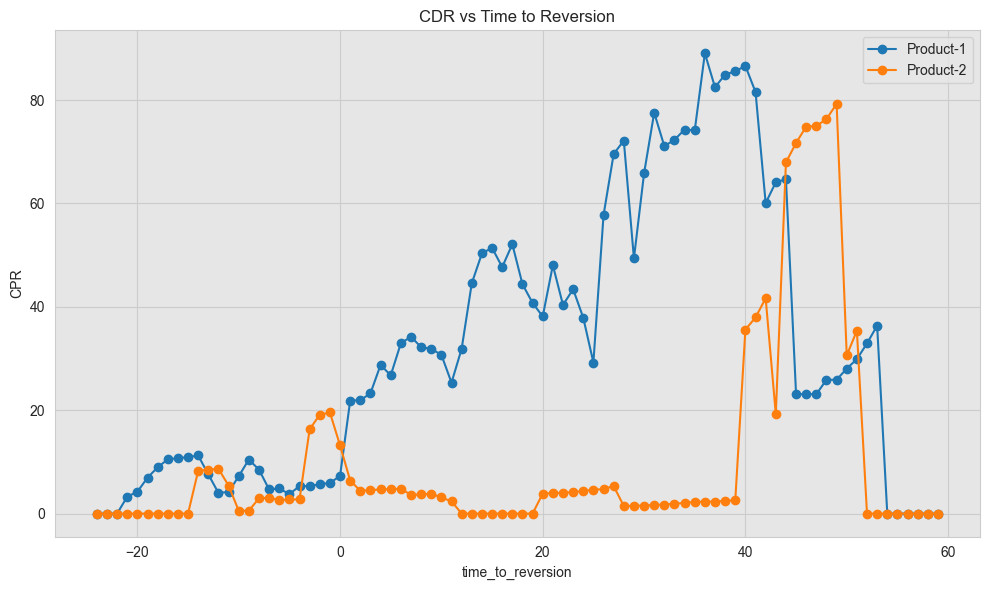

In [42]:
plot_curves([{'x': df_cpr_cdr_t2rev["time_to_reversion"], 'y':df_cpr_cdr_t2rev["cdr_1"], 'label': 'Product-1'}, {'x': df_cpr_cdr_t2rev["time_to_reversion"], 'y':df_cpr_cdr_t2rev["cdr_2"], 'label': 'Product-2'}], 'CDR vs Time to Reversion', 'time_to_reversion', 'CPR')

**Note:** Q9 - Q11 are in 02_cash_flow_modelling.ipynb